# Housing Price Predictions

## Step I: Accessing the Data

In [3]:
# get the data
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

# load data from file
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# load data into memory and display information
housing = load_housing_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


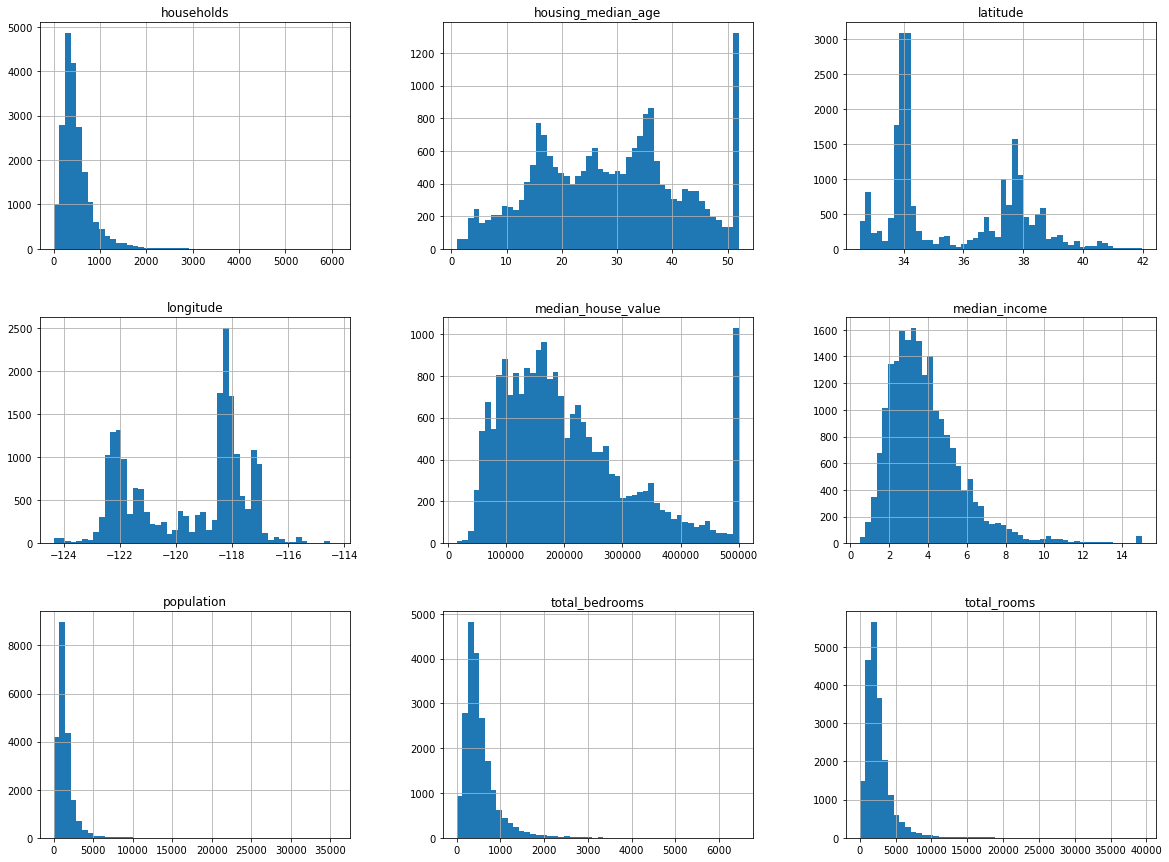

In [6]:
# print histogram of each attribute
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize=(20,15))
plt.show()

### Things to look out for

* capping of data (for example median_house_value and housing_median_age)
    * of those two, the former is the most grave since it is our label
    * option 1: have a look at the amount of capped data and whether it is neglectable or not
    * option 2: collect proper data for capped houses
    * option 3: remove capped entries from the training and test set
* unrealistic data (for example median_income with a scale from 0.5 to 15)
* different scales (will be sorted out later)
* many histograms are tail heavy (meaning that they extand much farther to the right than the left of the median)


## Step II: Create a Test Set

In [7]:
import numpy as np

np.random.seed(42) # returns the same random numbers every time

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # randomizes order of entries
    test_set_size = int(len(data) * test_ratio) # how many entries should the test set contain
    test_indices = shuffled_indices[:test_set_size] # assign the test entries out of the shuffled container (from 0 to test_set_size-1)
    train_indices = shuffled_indices[test_set_size:] # assign the rest of the shuffled entries to the training set (from test_set_size to the end)
    return data.iloc[train_indices], data.iloc[test_indices]

# This is bad, since each time this function is run, training and test set are going to be different.
# At some point, the algorithm will have seen all/most of the dataset, which we want to avoid

# Approach:
# use each instances unique identifier to decide whether it's part of the test set
# 1) compute hash for each instances identifier
# 2) keep only the last byte 
# 3) compare byte against 256 * test_ratio
#    if lower -> test set
#    if higher -> training set

import hashlib

def test_set_check(identifier, test_ratio, hash):
    # returns true if identifier is associated with the test set
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio # takes the last byte of the hashed identifier for comparison

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash)) #for each column, do 
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # adds 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')
test_set.head()
# Disadvatages: instances have to stay in the same order, no row may be deleted, new data has to be added to the bottom
# in order for ids to be the same over multiple iterations

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [8]:
# Alternative: use already existing unique identifying attribute to generate an id (here: latitude)
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


Random selection is good for large datasets but potentially really bad for smaller datasets, since the likelyhood of it not being representative of the actual dataset. The solution is to select a representative attribute (in our case median_income) after assesing it yourself or with the help of experts and then creating **stratas**(i.e hogenous subgroups to group continuous data by value spans). This is called **stratified sampling**.

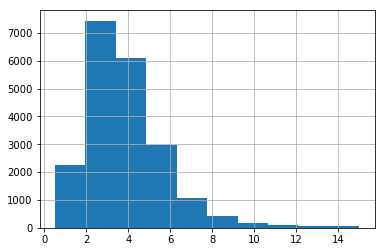

In [9]:
housing["median_income"].hist()

In the histogram we se that most median incomes are between 2 and 5 (k). It is important to keep a sufficient number of instances in each stratum in order to avoid any bias towards the importance of each stratum. We need to create an extra category for the stratas.

In [10]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5) #goal: limit amount of stratas
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
print(housing["income_cat"].value_counts()/len(housing))

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
print(strat_test_set["income_cat"].value_counts()/len(strat_test_set))

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


In [11]:
# after being done with separating test and train set, remove the category attribute
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Step III: Discover and Visualize the Data to Gain Insights

Important: do not use the test set for this to avoid any potential bias on yur side!

In [12]:
# creating a copy of the training set
train_copy = strat_train_set.copy()

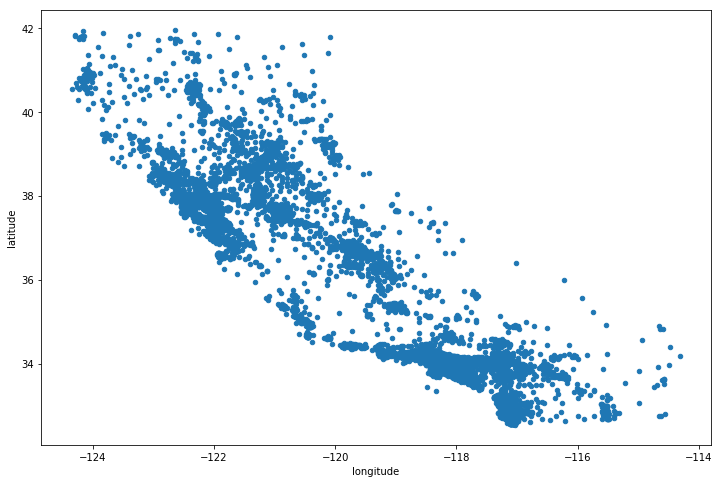

In [13]:
# Geographical Data
train_copy.plot(kind="scatter", x="longitude", y="latitude", figsize=(12,8))

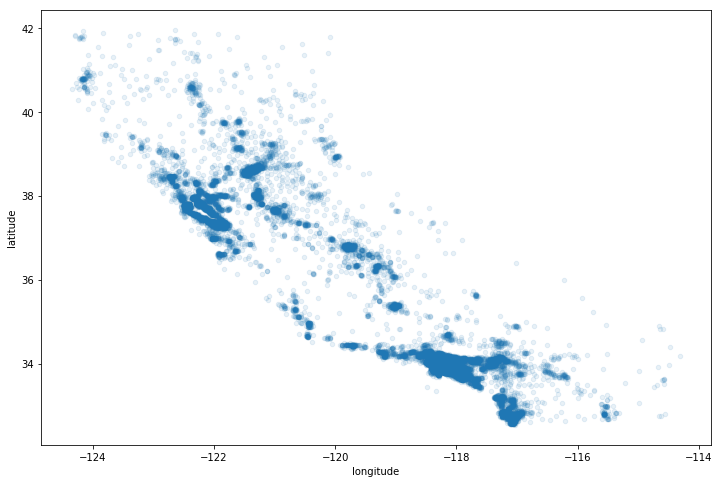

In [14]:
train_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(12,8))

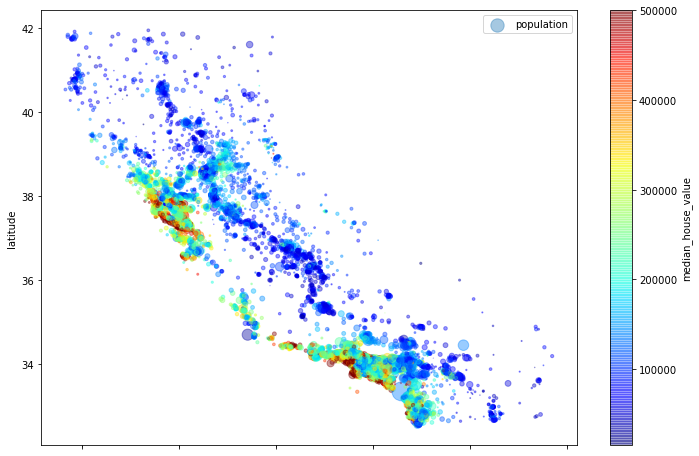

In [15]:
train_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
                s=train_copy["population"]/100, label="population", figsize=(12,8),
                c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
)
plt.legend()

In [16]:
corr_matrix = train_copy.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

# close to 1: strong positive correlation (i.e. median_income)
# close to -1: strong negative correlation (i.e.latitude, houses farther north tend to be less expensive)
# close to 0: little to no correlation

# IMPORTANT: the correlation coefficient only recognizes linear correlation, non-linear 
# correlation might still exist but is not picked up

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000212EC50DC88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000212EBC80AC8>]], dtype=object)

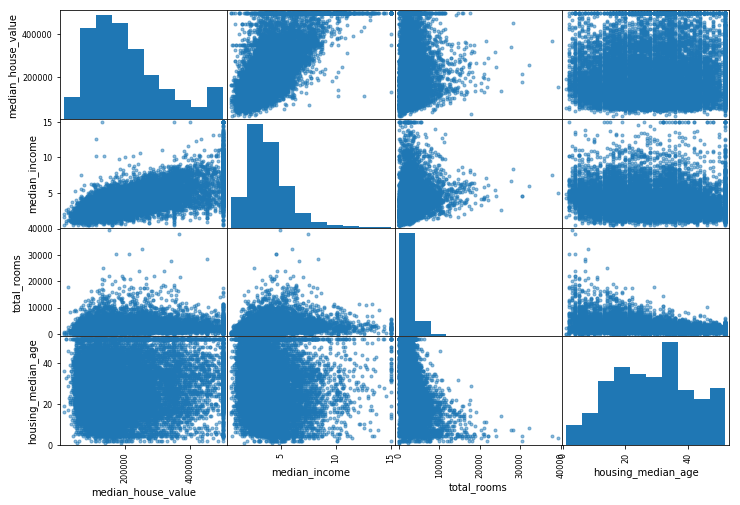

In [17]:
# use pandas to check for correlations
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(train_copy[attributes], figsize=(12,8))

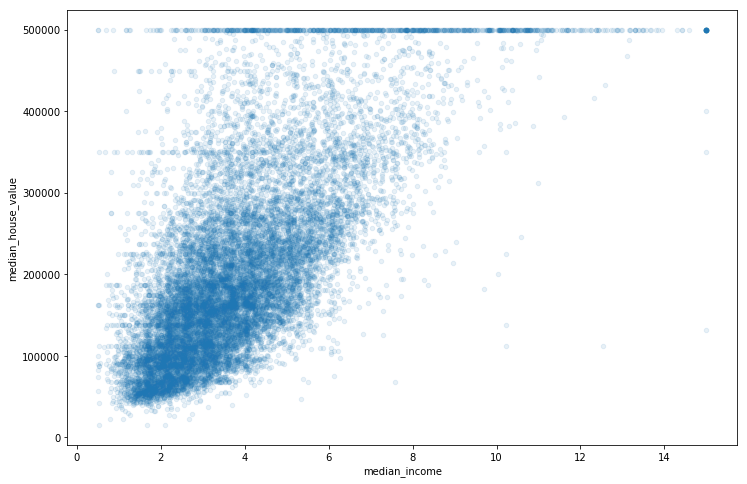

In [18]:
train_copy.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(12,8))

#### Interpretation:

* strong correlation, points are not too dispersed
* upwards trend is clearly visible
* Price cap is clearly visible at 500k
* a couple more straight lines at 450k, 350k, 280k, 230k, 140k, 120k --> might want to remove that (might be learned)


In [19]:
# Combining Attributes that might be more relevant than their respective parts
train_copy["rooms_per_household"] = train_copy["total_rooms"]/train_copy["households"]
train_copy["bedrooms_per_room"] = train_copy["total_bedrooms"]/train_copy["total_rooms"]
train_copy["population_per_household"] = train_copy["population"]/train_copy["households"]

corr_matrix = train_copy.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64


Axes(0.125,0.125;0.775x0.755)


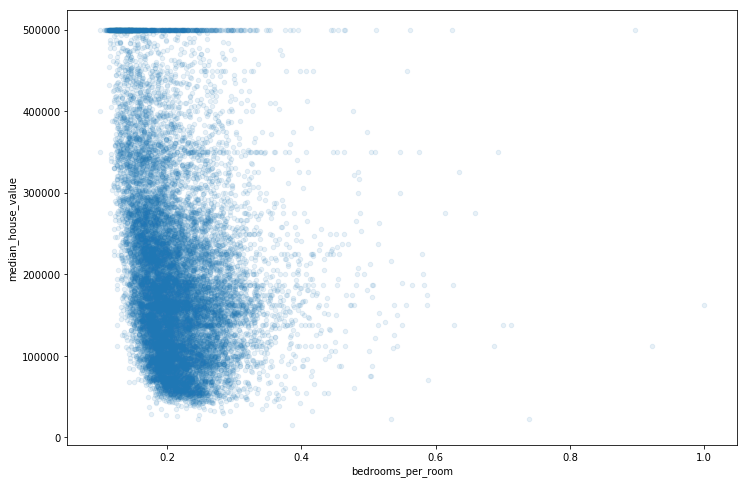

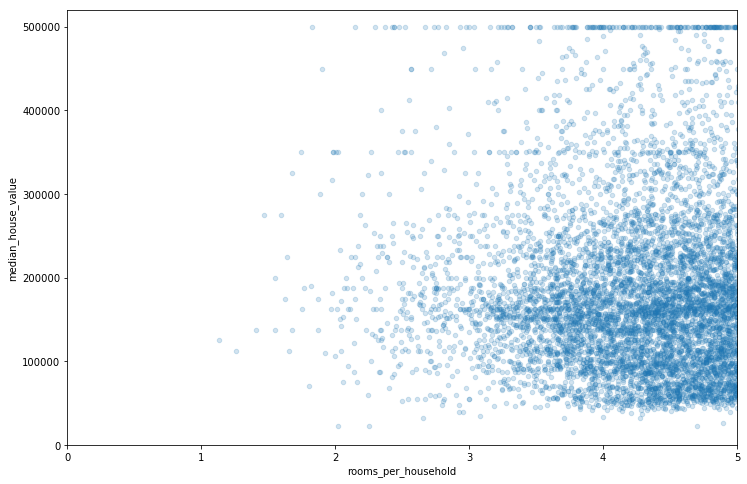

In [20]:
print(train_copy.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value", alpha=0.1, figsize=(12,8)))
train_copy.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2, figsize=(12,8))
plt.axis([0, 5, 0, 520000])
plt.show()

In [21]:
train_copy.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


## Step IV: Prepare the Data for Machine Learning Algorithms

In [22]:
# remove the target values from the training set since we don't want to change them
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [23]:
# Data Cleaning
# many/most ML algorithms can't handle missing data
# our issue: 
# opt1) get rid of instances with missing data --> housing.dropna
# opt2) get rid of the whole attribute --> housing.drop
# opt3) set the missing values to another value --> calc median, housing.fillna

In [25]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
# median works only on numeric data --> remove non numeric data
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
# results are saved in the statistics_ variable
print(imputer.statistics_)
print(housing_num.median().values)

[ -118.51      34.26      29.      2119.5      433.      1164.       408.
     3.5409]
[ -118.51      34.26      29.      2119.5      433.      1164.       408.
     3.5409]


In [26]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling Text and Categorical Attributes
Issue of standard encoding: algo presumes closer relation between 0 and 1 than for 0 and 4 --> solution: One Hot Encoding (one column hot, rest cold)

In [28]:
# Encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)
print(encoder.classes_)

[0 0 4 ..., 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [30]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [31]:
# sparse matrix => only documents where values are 1, since most are 0 for OneHot
print(housing_cat_1hot.toarray())

[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 ..., 
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]]


In [32]:
# Both encodings in 1 Step:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot =  encoder.fit_transform(housing_cat)
print(housing_cat_1hot)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 ..., 
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]


### Custom Transformers
useful for:
* cleanup operations
* combining attributes
* uses the standard scikit learn structure

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

### Feature Scaling
Extremely important, without it features with larger scales are weighted more heavily than others.

Two options: Normalization & Standardization

#### Normalization
min/(max-min)
scale from 0 - 1
--> MinMaxScaler

#### Standardization
subtract mean, divide by varaince
does not bind the values to a specific scale (problematic for some nerual networks)
but: not as prone to large outliers (most 1 - 10, one 1000)
--> StandardScaler

### Transformation Pipelines

Takes a list of name, estimator pairs and executes them one after the other.

In [44]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [46]:
housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared)
print(housing_prepared.shape)

[[-1.15604281  0.77194962  0.74333089 ...,  0.          0.          0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...,  0.          0.          0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...,  0.          0.          1.        ]
 ..., 
 [ 1.58648943 -0.72478134 -1.56295222 ...,  0.          0.          0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...,  0.          0.          0.        ]
 [-1.43579109  0.99645926  1.85670895 ...,  0.          1.          0.        ]]
(16512, 16)


## Select and Train a Model

### Training and Evaluation on the Training Set

In [48]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
# testing using the training set
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [50]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_mse = np.sqrt(lin_mse)
print(lin_mse)

68628.1981985


In [51]:
# model is underfitting the data!
# use Decision Trees as they are more powerful
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [52]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse = np.sqrt(tree_mse)
print(tree_mse)

0.0
